# Create EOPatch and fill it with L1C and derived data

Now is time to create an `EOPatch` for each out of 293 tiles of the AOI. The `EOPatch` is created by filling it with Sentinel-2 data using Sentinel Hub services. We will add the following data to each `EOPatch`:
* L1C RGB (bands B04, B03, and B02) 
* SentinelHub's cloud probability map and cloud mask 

Using the above information we can then also count how many times in a time series a pixel is valid or not from the cloud mask.

---

An `EOPatch` is created and manipulated using `EOTasks` chained in an `EOWorkflow`. In this example the final workflow is a sequence of the following tasks:
1. Create `EOPatch` by filling it with RGB L1C data, together with cloud masks and cloud probabilities from Sentinel-Hub (s2cloudless)
2. Validate pixels using the cloud mask
3. Count number of valid observations per pixel using valid data mask
4. Export valid pixel count to tiff file
5. Save EOPatch to disk

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

In [3]:
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, SaveTask, LoadTask, RemoveFeature, OverwritePermission
from eolearn.io import ExportToTiff
from eolearn.io import SentinelHubInputTask
from eolearn.mask import AddValidDataMaskTask
from eolearn.features import SimpleFilterTask

In [4]:
from sentinelhub import BBoxSplitter, CRS, MimeType, DataCollection

In [5]:
import logging
logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)

In [6]:
import pickle

In [7]:
from pathlib import Path

In [8]:
data = Path('./')

In [9]:
import os

In [10]:
if not os.path.exists(data/'data'/'valid_count-L1C'):
    os.makedirs(data/'data'/'valid_count-L1C')

### Get BBoxSplitter with tile definitions

In [11]:
with open(data/'tile-def'/'slovenia_buffered_bbox_32633_17x25_293.pickle','rb') as fp:
    bbox_splitter = pickle.load(fp)

In [12]:
len(bbox_splitter.bbox_list)

276

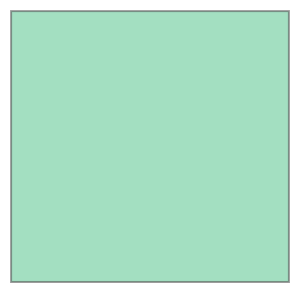

In [13]:
bbox_splitter.bbox_list[0]

In [14]:
bbox_splitter.info_list[0]

{'parent_bbox': BBox(((374082.76593436865, 5030247.492381066), (616267.611926655, 5190832.300434856)), crs=CRS('32633')),
 'index_x': 0,
 'index_y': 6}

# eo-learn Workflow to create patches

### Define what makes a pixel valid

#### SentinelHub's definition of valid pixel

Valid pixel is if:
   * `dataMask == True` 
   * `CLOUD_MASK == 0` (1 indicates that pixel was identified to be covered with cloud)

In [15]:
class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):        
        return np.logical_and(eopatch.mask['dataMask'].astype(np.bool), 
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))

### Define custom tasks

In [16]:
class CountValid(EOTask):   
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name
        
    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))
        
        return eopatch

## Initialise tasks

In [17]:
# 1. Create `EOPatch` by filling it with RGB L1C data
# Add RGB, dataMask, cloud mask (CLM) and cloud probabilities (CLP) from service
input_task = SentinelHubInputTask(data_collection=DataCollection.SENTINEL2_L1C,
                                  resolution=(10,10),
                                  bands=['B04', 'B03', 'B02'],
                                  bands_feature=(FeatureType.DATA, 'TRUE-COLOR-S2-L1C'),
                                  additional_data=[(FeatureType.MASK, 'dataMask'), (FeatureType.MASK, 'CLM'), (FeatureType.DATA, 'CLP')],
                                  maxcc=0.8
                                 )

# 2. Validate pixels using SentinelHub's cloud detection mask
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(), 'VALID_DATA_SH')

# 3. Count number of valid observations per pixel using valid data mask 
count_val_sh = CountValid('VALID_DATA_SH', 'VALID_COUNT_SH')

# 4. Export valid pixel count to tiff file
export_val_sh = ExportToTiff((FeatureType.MASK_TIMELESS, 'VALID_COUNT_SH'))

# 5. Save EOPatch to disk
save = SaveTask(str(data/'data'/'eopatch-L1C'), overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

## Define workflow

In this example the workflow is linear

In [18]:
workflow = LinearWorkflow(input_task,
                          add_sh_valmask, count_val_sh,
                          export_val_sh, save)

In [19]:
time_interval = ['2017-01-01','2017-12-31']

idx = 0
bbox = bbox_splitter.bbox_list[idx]
info = bbox_splitter.info_list[idx]
tiff_name = f'val_count_sh_eopatch_{idx}_row-{info["index_x"]}_col-{info["index_y"]}.tiff'
patch_name = f'eopatch_{idx}_row-{info["index_x"]}_col-{info["index_y"]}'
results = workflow.execute({input_task:{'bbox':bbox, 'time_interval':time_interval},
                            export_val_sh:{'filename':str(data/'data'/'valid_count-L1C'/tiff_name)},
                            save:{'eopatch_folder':patch_name}
                           })

In [20]:
patch = list(results.values())[-1]

#### Check the content of the EOPatch

In [21]:
patch

EOPatch(
  data: {
    CLP: numpy.ndarray(shape=(82, 945, 969, 1), dtype=uint8)
    TRUE-COLOR-S2-L1C: numpy.ndarray(shape=(82, 945, 969, 3), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(82, 945, 969, 1), dtype=uint8)
    VALID_DATA_SH: numpy.ndarray(shape=(82, 945, 969, 1), dtype=bool)
    dataMask: numpy.ndarray(shape=(82, 945, 969, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    VALID_COUNT_SH: numpy.ndarray(shape=(945, 969, 1), dtype=int64)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.8
    service_type: 'processing'
    size_x: 969
    size_y: 945
    time_difference: datetime.timedelta(seconds=1)
    time_interval: (datetime.datetime(2017, 1, 1, 0, 0), datetime.datetime(2017, 12, 31, 23, 59, 59))
  }
  bbox: BBox(((374082.76593436865, 5086924.483458874), (383770.1597740601, 5096370.648638509)), crs=CRS('32633'))
  timestamp: [datetime.datetime(2017, 1, 1, 10, 4, 

In [22]:
patch.timestamp

[datetime.datetime(2017, 1, 1, 10, 4, 7),
 datetime.datetime(2017, 1, 4, 10, 14, 5),
 datetime.datetime(2017, 1, 11, 10, 3, 51),
 datetime.datetime(2017, 1, 14, 10, 13, 46),
 datetime.datetime(2017, 1, 24, 10, 14, 7),
 datetime.datetime(2017, 2, 10, 10, 1, 32),
 datetime.datetime(2017, 2, 20, 10, 6, 35),
 datetime.datetime(2017, 3, 2, 10, 0, 20),
 datetime.datetime(2017, 3, 12, 10, 7, 6),
 datetime.datetime(2017, 3, 15, 10, 12, 14),
 datetime.datetime(2017, 3, 25, 10, 10, 18),
 datetime.datetime(2017, 4, 1, 10, 0, 22),
 datetime.datetime(2017, 4, 4, 10, 11, 19),
 datetime.datetime(2017, 4, 11, 10, 0, 25),
 datetime.datetime(2017, 4, 14, 10, 13, 50),
 datetime.datetime(2017, 4, 21, 10, 5, 41),
 datetime.datetime(2017, 4, 24, 10, 11, 20),
 datetime.datetime(2017, 5, 4, 10, 13, 49),
 datetime.datetime(2017, 5, 11, 10, 5, 39),
 datetime.datetime(2017, 5, 14, 10, 11, 25),
 datetime.datetime(2017, 5, 21, 10, 0, 29),
 datetime.datetime(2017, 5, 24, 10, 13, 53),
 datetime.datetime(2017, 5, 31,

#### Plot RGB, SCL, and Cloud probability, and number of valid observations

In [23]:
def plot_frame(patch, idx, scale=1, save_fig=False):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,20)) 

    axs[0,0].imshow(scale*patch.data['TRUE-COLOR-S2-L1C'][idx])
    axs[0,0].set_title(f'RGB {patch.timestamp[idx]}') 
    axs[0,1].imshow(patch.mask['VALID_DATA_SH'][idx, ..., 0],vmin=0,vmax=1)
    axs[0,1].set_title(f'Valid data {patch.timestamp[idx]}') 
    axs[1,0].imshow(patch.mask['CLM'][idx,...,0],vmin=0,vmax=1)
    axs[1,0].set_title(f'SentinelHub Cloud Mask {patch.timestamp[idx]}') 
    divider = make_axes_locatable(axs[1,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = axs[1,1].imshow(patch.data['CLP'][idx,...,0]/255.,cmap=plt.cm.inferno, vmin=0.0, vmax=1.0)
    fig.colorbar(im, cax=cax, orientation='vertical')
    axs[1,1].imshow(patch.data['CLP'][idx,...,0]/255.,cmap=plt.cm.inferno)
    axs[1,1].set_title(f'SentinelHub Cloud Probability {patch.timestamp[idx]}') 
    
    if save_fig:
        fig.savefig(f'figs/patch_{idx}_{patch.timestamp[idx]}.png', bbox_inches='tight')
        fig.clf()

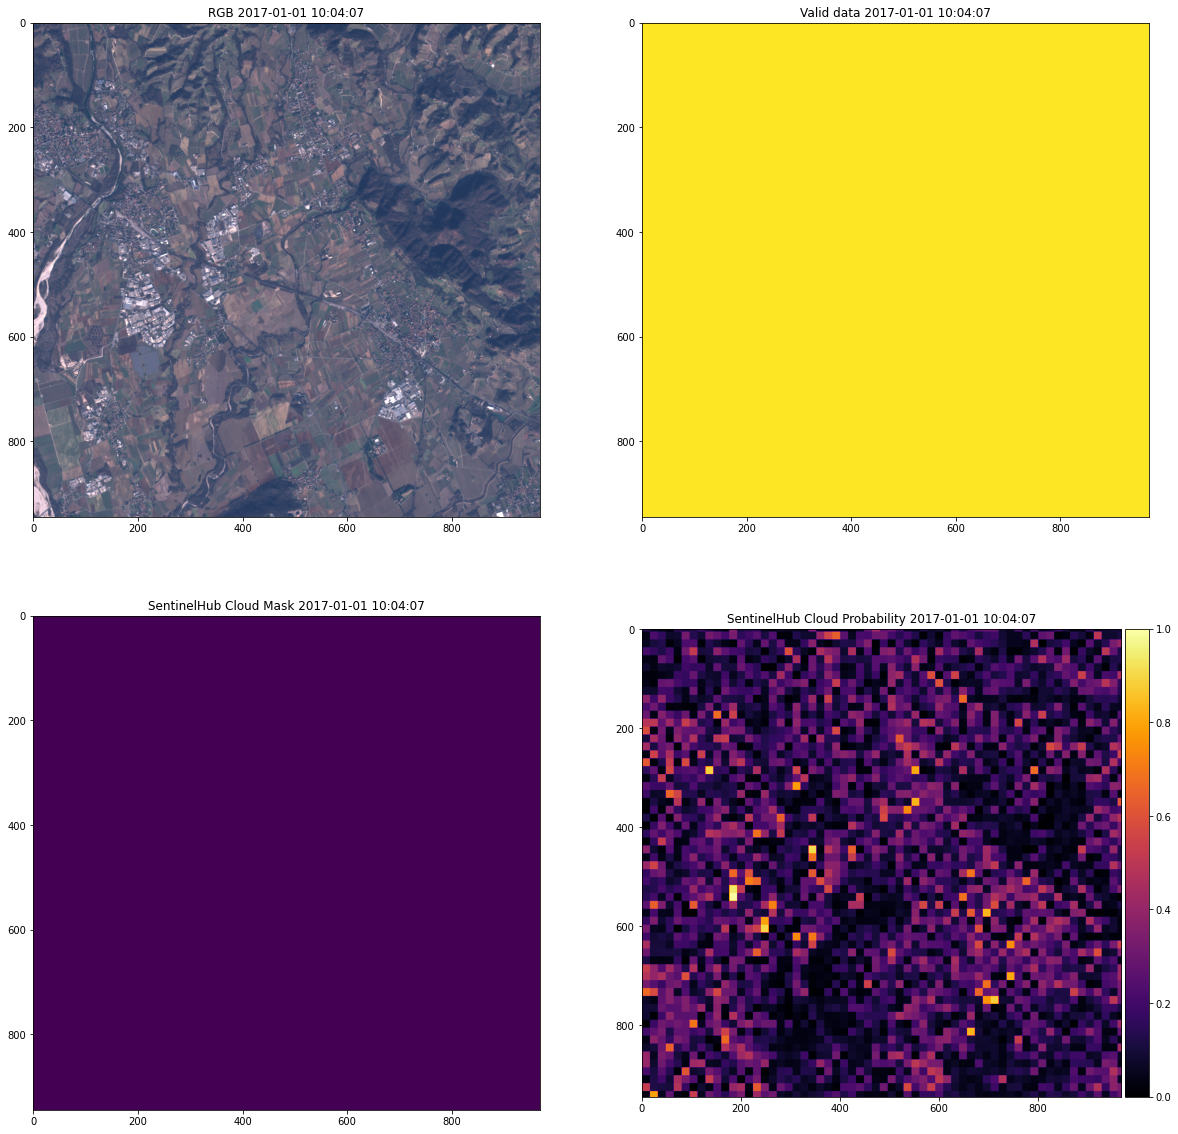

In [24]:
plot_frame(patch, 0, scale=3.5)

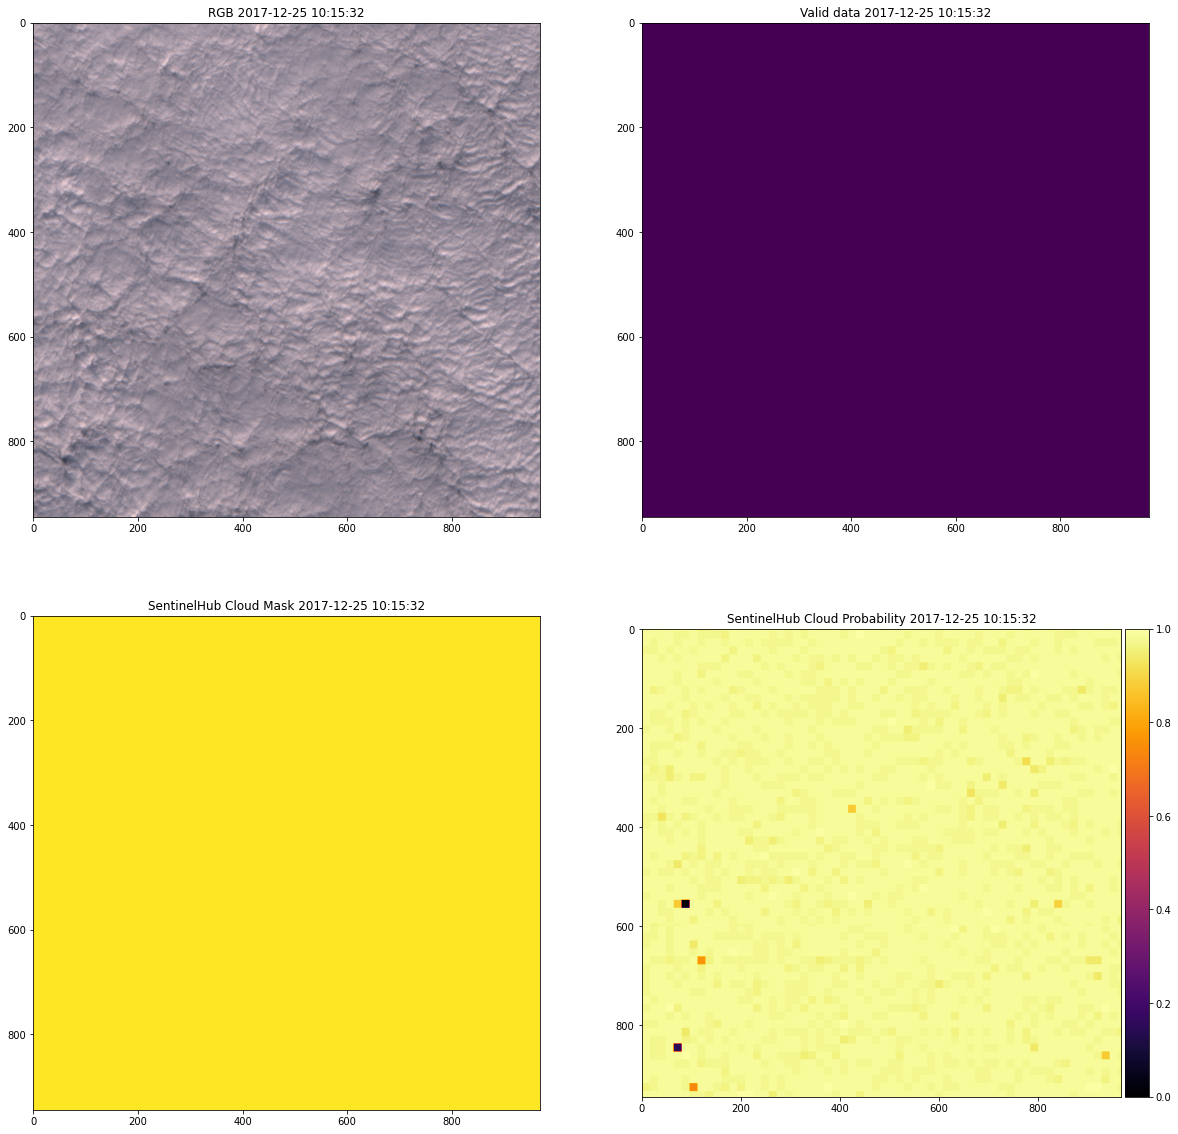

In [25]:
plot_frame(patch, -1)

#### Plot number of valid observations

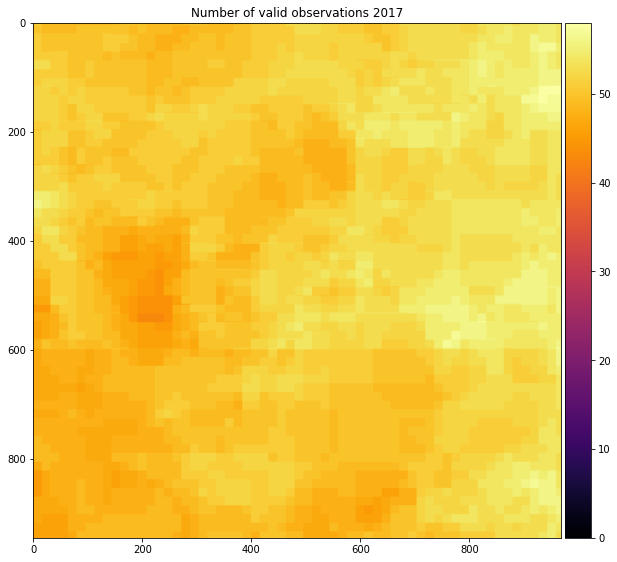

In [26]:
fig, ax = plt.subplots(figsize=(10,10)) 
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(patch.mask_timeless['VALID_COUNT_SH'][...,0], cmap=plt.cm.inferno, vmin=0, vmax=np.max(patch.mask_timeless['VALID_COUNT_SH']))
ax.set_title('Number of valid observations 2017');
fig.colorbar(im, cax=cax, orientation='vertical')
fig.savefig(f'figs/number_of_valid_observations_eopatch_0.png', bbox_inches='tight')

#### Plot average cloud probability

In [27]:
avecld = np.sum(patch.data['CLP'][...,0],axis=(0))/patch.data['CLP'].shape[0]
avecld/=255.

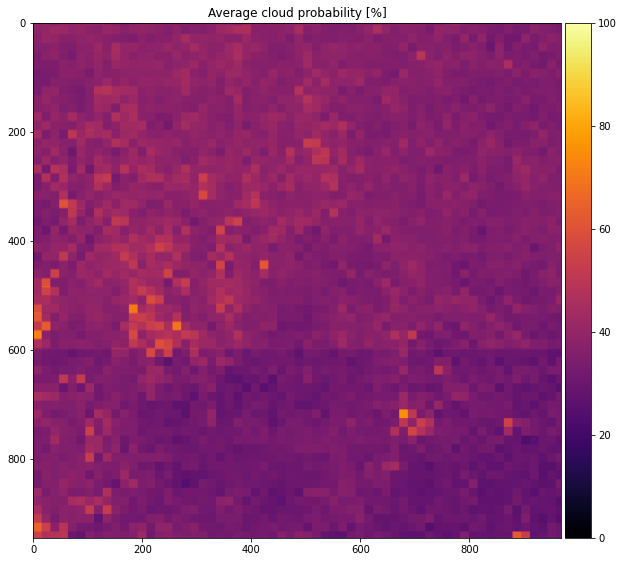

In [28]:
fig, ax = plt.subplots(figsize=(10,10)) 
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(avecld*100, cmap=plt.cm.inferno, vmin=0, vmax=100.0)
ax.set_title('Average cloud probability [%]');
fig.colorbar(im, cax=cax, orientation='vertical');

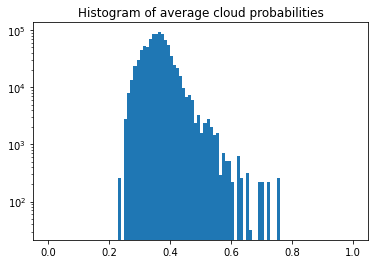

In [29]:
plt.hist((avecld).flatten(),range=(0,1), bins=100, log=True);
plt.title('Histogram of average cloud probabilities');

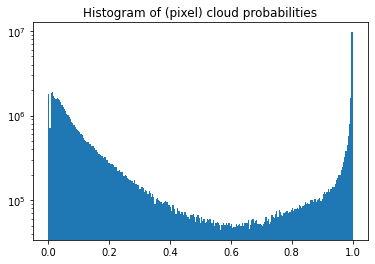

In [30]:
plt.hist((patch.data['CLP']).flatten()/255.,range=(0,1), bins=255, log=True);
plt.title('Histogram of (pixel) cloud probabilities');

#### Plot fraction of valid pixels per frame

In [31]:
def valid_fraction(arr):
    """
    Calculates fraction of non-zero pixels.
    """
    return np.count_nonzero(arr)/np.size(arr)

In [32]:
valid_frac = np.apply_along_axis(valid_fraction,axis=1,arr=np.reshape(patch.mask['VALID_DATA_SH'], (patch.mask['VALID_DATA_SH'].shape[0], -1)))

In [33]:
valid_frac.shape

(82,)

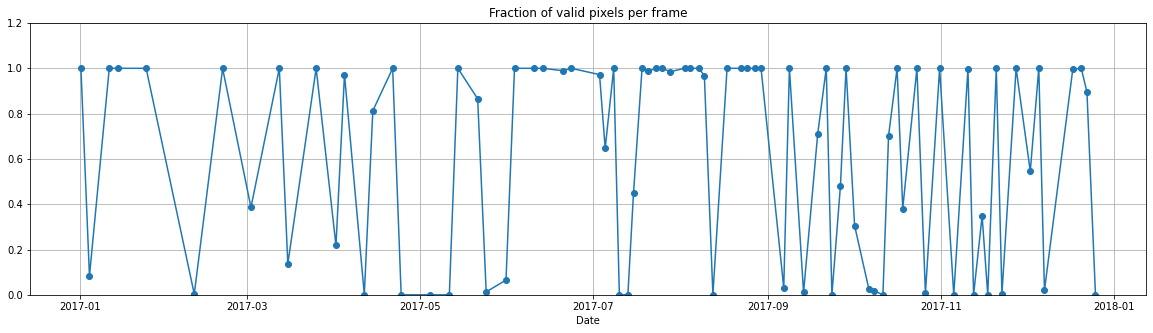

In [34]:
fig, ax = plt.subplots(figsize=(20,5)) 
ax.plot(patch.timestamp, valid_frac,'o-')
ax.set_title('Fraction of valid pixels per frame');
ax.set_xlabel('Date');
ax.set_ylim(0.0,1.2)
ax.grid()
fig.savefig('figs/fraction_valid_pixels_per_frame_eopatch-0.png', bbox_inches='tight')

## Remove too cloudy frames

After inspection of the individual frames in the time series it gets clear that some frames are useless for further analysis -- covered almost completely with clouds. Let's remove frames with 60% or less valid pixels.

For this purpose we will define a new workflow which will:
1. Read EOPatch from disk
2. Remove frames with fraction of valid pixels below 60%

In the real world example the last two tasks would be part of the original workflow defined above.

### Define and initalise tasks

In [35]:
class AddValidDataFraction(EOTask):
    def execute(self, eopatch):
        vld = eopatch.get_feature(FeatureType.MASK, 'VALID_DATA_SH')
        frac = np.apply_along_axis(valid_fraction, 1, np.reshape(vld, (vld.shape[0], -1)))
        
        eopatch.add_feature(FeatureType.SCALAR, 'VALID_FRAC', frac[:,np.newaxis])
        return eopatch

In [36]:
class ValidDataFractionPredicate:
    def __init__(self, threshold):
        self.threshold = threshold
        
    def __call__(self, array):
        coverage = array[...,0]
        return coverage > self.threshold

In [37]:
load = LoadTask(str(data/'data'/'eopatch-L1C'))
add_coverage = AddValidDataFraction()
remove_cloudy_scenes = SimpleFilterTask((FeatureType.SCALAR, 'VALID_FRAC'), ValidDataFractionPredicate(0.6))

In [38]:
clean_up_work = LinearWorkflow(load, add_coverage, remove_cloudy_scenes)

In [39]:
idx = 0
bbox = bbox_splitter.bbox_list[idx]
info = bbox_splitter.info_list[idx]
patch_name = f'eopatch_{idx}_row-{info["index_x"]}_col-{info["index_y"]}'
cleaned_up_results = clean_up_work.execute({load:{'eopatch_folder':patch_name}
                                           })

In [40]:
cleaned_patch = list(cleaned_up_results.values())[-1]

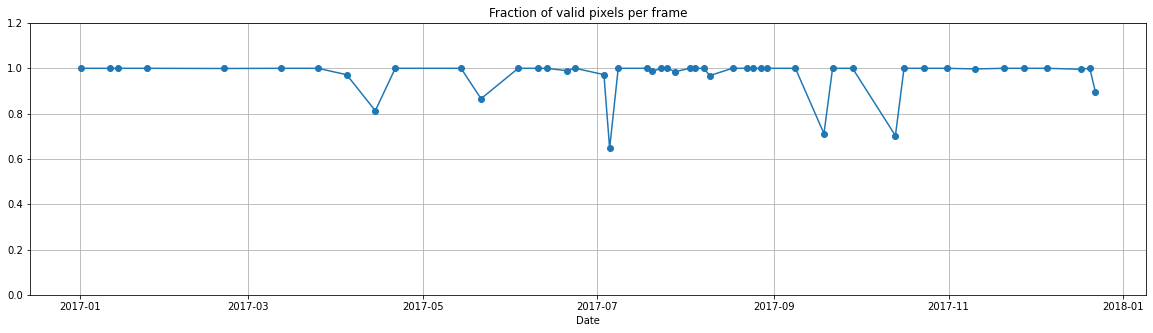

In [41]:
fig, ax = plt.subplots(figsize=(20,5)) 
ax.plot(cleaned_patch.timestamp, cleaned_patch.scalar['VALID_FRAC'][...,0],'o-')
ax.set_title('Fraction of valid pixels per frame');
ax.set_xlabel('Date');
ax.set_ylim(0.0,1.2)
ax.grid()
fig.savefig('figs/fraction_valid_pixels_per_frame_cleaned-eopatch-0.png', bbox_inches='tight')

Number of valid frames

In [42]:
print(len(cleaned_patch.timestamp))

49


## Putting everything together

Create a single workflow with all tasks.

In [43]:
# 1. Create `EOPatch` by filling it with RGB L1C data
input_task = SentinelHubInputTask(data_collection=DataCollection.SENTINEL2_L1C,
                                  resolution=(10,10),
                                  bands=[],
                                  additional_data=[(FeatureType.MASK, 'dataMask'), (FeatureType.MASK, 'CLM'), (FeatureType.DATA, 'CLP')],
                                  maxcc=0.8
                                 )

# 2. Validate pixels using SentinelHub's cloud detection mask
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(), 'VALID_DATA_SH')


# 3. Calculate fraction of valid pixels
add_coverage = AddValidDataFraction()

# 4. Remove frames with fraction of valid pixels below 60%
remove_cloudy_scenes = SimpleFilterTask((FeatureType.SCALAR, 'VALID_FRAC'), ValidDataFractionPredicate(0.6))


# 5. Count number of valid observations per pixel using valid data mask 
count_val_sh = CountValid('VALID_DATA_SH', 'VALID_COUNT_SH')

# 6. Export valid pixel count to tiff file
export_val_sh = ExportToTiff((FeatureType.MASK_TIMELESS, 'VALID_COUNT_SH'))

# 7. Save EOPatch to disk
save = SaveTask(str(data/'data'/'eopatch-L1C'), overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [44]:
final_workflow = LinearWorkflow(input_task, add_sh_valmask, add_coverage, remove_cloudy_scenes, count_val_sh, export_val_sh, save)

In [45]:
def execute_workflow(tile_idx):
    bbox = bbox_splitter.bbox_list[tile_idx]
    info = bbox_splitter.info_list[tile_idx]
    tiff_name = f'val_count_sh_cleaned_eopatch_{tile_idx}_row-{info["index_x"]}_col-{info["index_y"]}.tiff'
    patch_name = f'eopatch_{tile_idx}_row-{info["index_x"]}_col-{info["index_y"]}'
    results = final_workflow.execute({input_task:{'bbox':bbox, 'time_interval':time_interval},
                                      export_val_sh:{'filename':str(data/'data'/'valid_count-L1C'/tiff_name)},
                                      save:{'eopatch_folder':patch_name}
                                     })
    del results

In [46]:
time_interval = ['2017-01-01','2017-12-31']

In [47]:
execute_workflow(0)

Next step would be to run the workflow over all 293 tiles.